# Introduction

- This report studies basic static models with the features and labels defined in the API functions.
- Feature details: Features.ipynb
- Label details: Labels.ipynb

# Packages

In [1]:
import collections
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, compose, model_selection
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import API

# Data engineering 

- Reminders
    - ID: Unique index
    - OCCUPATION_TYPE: Missing values replaced with Unknown
    - DAYS_EMPLOYED: Replaced large number with `column mean` and add an `indicator column`
    - FLAG_EMPLOYED: True indicate DAYS_EMPLOYED < 0, while False indicate the large data we fill in with mean
    - Label: overdue more than 30 days as default, about 13%
- **More details in `Features.ipynb` and `Labels.ipynb`**
- **The pair plot seems reasonable**

In [3]:
features=API.get_features()
features

data shape (438557, 17)
data shape after removing duplicates and setting ID (438463, 16)
data shape after removing outliers and adding indicators (438437, 17)


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,FLAG_EMPLOYED
ID,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,5.630936,Working,Higher education,Civil marriage,Rented apartment,-12005,8.421123,1,0,0,Unknown,2.0,True
5008805,M,Y,Y,0,5.630936,Working,Higher education,Civil marriage,Rented apartment,-12005,8.421123,1,0,0,Unknown,2.0,True
5008806,M,Y,Y,0,5.051153,Working,Secondary / secondary special,Married,House / apartment,-21474,7.033506,0,0,0,Security staff,2.0,True
5008808,F,N,Y,0,5.431364,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,8.023225,0,1,1,Sales staff,1.0,True
5008809,F,N,Y,0,5.431364,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,8.023225,0,1,1,Sales staff,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840104,M,N,Y,0,5.130334,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,7.872131,0,0,0,Unknown,1.0,False
6840222,F,N,N,0,5.014940,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,8.008698,0,0,0,Laborers,1.0,True
6841878,F,N,N,0,4.732394,Commercial associate,Higher education,Single / not married,With parents,-8169,5.918894,1,0,0,Sales staff,1.0,True


In [4]:
labels=API.get_labels()
labels.value_counts()

False    36099
True      5350
Name: label, dtype: int64

In [5]:
ID=features.index.intersection(labels.index)
len(ID)

33104

In [6]:
X=features.loc[ID]
Y=labels.loc[ID]
X.shape, Y.shape, Y.sum()

((33104, 17), (33104,), 4287)

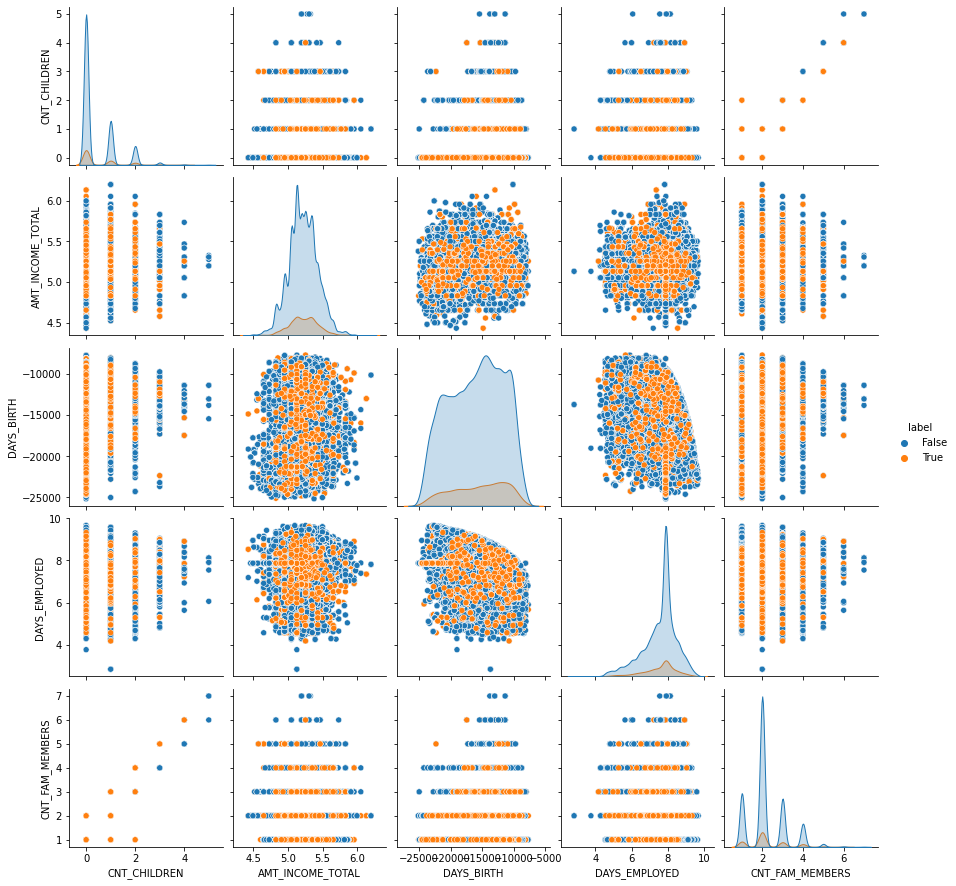

In [7]:
data=pd.concat([X, Y], axis=1)
sns.pairplot(data, hue='label')

# Train Test Split
- Problem: imbalance class may cause overfitting problem in our models
- Solution: sampling with replacement from positive ids

In [8]:
features.dtypes

CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED          float64
FLAG_WORK_PHONE         object
FLAG_PHONE              object
FLAG_EMAIL              object
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
FLAG_EMPLOYED           object
dtype: object

In [9]:
features_categorical = features.columns[features.dtypes==object]
features_numerical = features.columns.difference(features_categorical)
features_transformer = compose.ColumnTransformer([
    ('dummy', preprocessing.OneHotEncoder(drop='first'), features_categorical),
    ('ss', preprocessing.StandardScaler(), features_numerical),
])
features_transformer

ColumnTransformer(transformers=[('dummy', OneHotEncoder(drop='first'),
                                 Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'FLAG_EMPLOYED'],
      dtype='object')),
                                ('ss', StandardScaler(),
                                 Index(['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'DAYS_BIRTH',
       'DAYS_EMPLOYED'],
      dtype='object'))])

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=10)
X_train.shape, X_test.shape, y_train.sum(), y_test.sum()

((26483, 17), (6621, 17), 3432, 855)

In [11]:
rng = np.random.default_rng(1234)
p_train=y_train.index[y_train==1] # id with positive labels
n_train=y_train.index[y_train==0] # id with negative labels
s_train=rng.choice(p_train, len(n_train)) # sampling with replacement from positive ids
I_sample=n_train.union(s_train)
X_sample=X_train.loc[I_sample]
y_sample=y_train.loc[I_sample]
y_sample.value_counts()

False    23051
True     23051
Name: label, dtype: int64

# Decision Tree

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


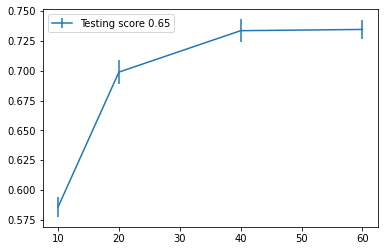

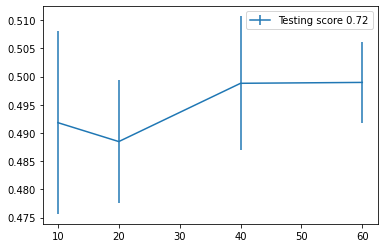

In [12]:
from sklearn.tree import DecisionTreeClassifier
def decision_tree_report(X_train, y_train):
    model = Pipeline([
        ('ft', features_transformer),
        ('model', DecisionTreeClassifier())
    ])
    parameters = {
        'model__max_depth': [10, 20, 40, 60],
    }
    clf = model_selection.GridSearchCV(model, parameters, scoring='roc_auc', verbose=1)
    clf.fit(X_train, y_train)
    res=pd.DataFrame(clf.cv_results_).fillna('None')
    scr=metrics.roc_auc_score(y_test, clf.predict(X_test))
    plt.errorbar(res['param_model__max_depth'], res['mean_test_score'],
                 yerr=res['std_test_score'],
                 label=f'Testing score {scr:.2f}',
                )
    plt.legend()

plt.figure()
decision_tree_report(X_train, y_train)
plt.figure()
decision_tree_report(X_sample, y_sample)

## Summary

- both models (with original and resampled train data) perform best with `max_depth=40`
- the original data leads to overfitting while resampled data leads to underfitting
- the resampled data leads to larger variances
- resampled data could improve test score

# Random Forest

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


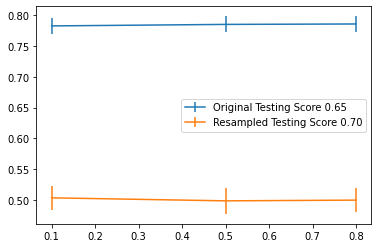

In [13]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_report(X_train, y_train, name=''):
    model = Pipeline([
        ('ft', features_transformer),
        ('model', RandomForestClassifier(max_features='auto'))
    ])
    parameters = {
        'model__max_features': [0.1, 0.5, 0.8],
    }
    #max_features= [2,3,4] bootstrap = [True,False] oob_score = [True,False]
    clf = model_selection.GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=-1, verbose=3)
    clf.fit(X_train, y_train)
    res=pd.DataFrame(clf.cv_results_).fillna('None')
    scr=metrics.roc_auc_score(y_test, clf.predict(X_test))
    plt.errorbar(res['param_model__max_features'], res['mean_test_score'],
                 yerr=res['std_test_score'],
                 label=f'{name} Testing Score {scr:.2f}'.strip(),
                )
    plt.legend()

random_forest_report(X_train, y_train, 'Original')
random_forest_report(X_sample, y_sample, 'Resampled')

## Summary

- similar with decision tree ...

# Neurual Network

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


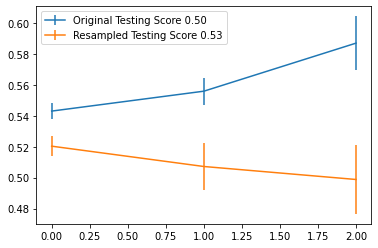

In [16]:
from sklearn.neural_network import MLPClassifier
def mlp_report(X_train, y_train, name):
    model = Pipeline([
        ('ft', features_transformer),
        ('model', MLPClassifier(max_iter=500))
    ])
    parameters = {
        'model__hidden_layer_sizes': [[],[5],[10]],
    }
    clf = model_selection.GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=-1, verbose=3)
    clf.fit(X_train, y_train)
    res=pd.DataFrame(clf.cv_results_).fillna('None')
    scr=metrics.roc_auc_score(y_test, clf.predict(X_test))
    plt.errorbar(range(len(parameters['model__hidden_layer_sizes'])), res['mean_test_score'],
                 yerr=res['std_test_score'],
                 label=f'{name} Testing Score {scr:.2f}',
                )
    plt.legend()

mlp_report(X_train, y_train, 'Original')
mlp_report(X_sample, y_sample, 'Resampled')

## Summary

- the empty hidden layer sizes is for simple logistic regression
- very likely more powerful computing resources and deeper models are necessary to improve the results

# Conclusion

- Some results are reasonable, but models generally do not perform well on this dataset
- More models are tried offline but not included in the report
- Next step: add dynamic features to improve the performance